# Projekt z przedmiotu Podstawy Reprezentacji i Analizy Danych

### Temat Projektu - Twitter

## Część pierwsza - Eksploracyjna Analiza Danych

In [107]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# zmiana sposobu wyświetlania danych typu float
pd.options.display.float_format = "{:.2f}".format

import re

## Wczytanie i czyszczenie danych

In [163]:
df = pd.read_csv("gender-classifier-DFE-791531.csv", encoding = "latin1", engine='python', usecols=[5, 6, 10, 11, 13, 14, 17, 18, 19, 21])
df.head()

,gender,gender:confidence,description,fav_number,link_color,name,retweet_count,sidebar_color,text,tweet_count
0,male,1.00,i sing my own rhythm.,0,08C2C2,sheezy0,0,FFFFFF,Robbie E Responds To Critics After Win Against...,110964
1,male,1.00,I'm the author of novels filled with family dr...,68,0084B4,DavdBurnett,0,C0DEED,ÛÏIt felt like they were my friends and I was...,7471
2,male,0.66,louis whining and squealing and all,7696,ABB8C2,lwtprettylaugh,1,C0DEED,i absolutely adore when louis starts the songs...,5617
3,male,1.00,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",202,0084B4,douggarland,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,1693
4,female,1.00,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,37318,3B94D9,WilfordGemma,0,0,Watching Neighbours on Sky+ catching up with t...,31462


In [164]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20050 entries, 0 to 20049
Data columns (total 10 columns):
gender               19953 non-null object
gender:confidence    20024 non-null float64
description          16306 non-null object
fav_number           20050 non-null int64
link_color           20050 non-null object
name                 20050 non-null object
retweet_count        20050 non-null int64
sidebar_color        20050 non-null object
text                 20050 non-null object
tweet_count          20050 non-null int64
dtypes: float64(1), int64(3), object(6)
memory usage: 1.5+ MB


In [165]:
(df.isna()
 .sum(axis=0))

gender                 97
gender:confidence      26
description          3744
fav_number              0
link_color              0
name                    0
retweet_count           0
sidebar_color           0
text                    0
tweet_count             0
dtype: int64

In [166]:
df.keys()

Index(['gender', 'gender:confidence', 'description', 'fav_number',
       'link_color', 'name', 'retweet_count', 'sidebar_color', 'text',
       'tweet_count'],
      dtype='object')

## TODO Zmiana dziwnych znaków na emoji

In [167]:
str(df.loc[1, ['text']])

'text    \x89ÛÏIt felt like they were my friends and I was...\nName: 1, dtype: object'

Usunięcie rekordów z pewnością płci mniejszą niż 0.85 lub płcią nieznaną

In [168]:
df = df.where((df['gender:confidence'] > 0.9) & (df['gender'] != 'unknown')).dropna()
df.head()

,gender,gender:confidence,description,fav_number,link_color,name,retweet_count,sidebar_color,text,tweet_count
0,male,1.00,i sing my own rhythm.,0.00,08C2C2,sheezy0,0.00,FFFFFF,Robbie E Responds To Critics After Win Against...,110964.00
1,male,1.00,I'm the author of novels filled with family dr...,68.00,0084B4,DavdBurnett,0.00,C0DEED,ÛÏIt felt like they were my friends and I was...,7471.00
3,male,1.00,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",202.00,0084B4,douggarland,0.00,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,1693.00
4,female,1.00,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,37318.00,3B94D9,WilfordGemma,0.00,0,Watching Neighbours on Sky+ catching up with t...,31462.00
5,female,1.00,you don't know me.,3901.00,F5ABB5,monroevicious,0.00,0,"Ive seen people on the train with lamps, chair...",20036.00


In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11779 entries, 0 to 20049
Data columns (total 10 columns):
gender               11779 non-null object
gender:confidence    11779 non-null float64
description          11779 non-null object
fav_number           11779 non-null float64
link_color           11779 non-null object
name                 11779 non-null object
retweet_count        11779 non-null float64
sidebar_color        11779 non-null object
text                 11779 non-null object
tweet_count          11779 non-null float64
dtypes: float64(4), object(6)
memory usage: 1012.3+ KB


In [170]:
df = df.drop(columns=['gender:confidence'])

In [171]:
def hexToRGB(color):
    if color == '0':
        return 255, 255, 255
    if len(color)<5:
        return 255, 255, 255
    try:
        color = color.replace(".", "")
        color = color.replace("+", "")
        r=int(color[0:2],16)
        g=int(color[2:4],16)
        b=int(color[4:6],16)
    except (RuntimeError, TypeError, NameError, ValueError):
        return None, None, None
    else:
        return r,g,b
    

Dodanie kolumn z wartościami RGB kolorów w kolumnach link_color i sidebar_color

In [181]:
#print("Zmeniam kolory z postaci #RRGGBB w wersji hex na (rr,gg,bb) w wersji dec")
df["link_color_R"] = df["link_color"].apply(lambda x: hexToRGB(str(x))[0])
df["link_color_G"] = df["link_color"].apply(lambda x: hexToRGB(str(x))[1])
df["link_color_B"] = df["link_color"].apply(lambda x: hexToRGB(str(x))[2])
df["sidebar_color_R"] = df["sidebar_color"].apply(lambda x: hexToRGB(str(x))[0])
df["sidebar_color_G"] = df["sidebar_color"].apply(lambda x: hexToRGB(str(x))[1])
df["sidebar_color_B"] = df["sidebar_color"].apply(lambda x: hexToRGB(str(x))[2])

df = df.dropna()
df.loc[:, ['link_color', 'sidebar_color', 'link_color_R', 'link_color_G', 'link_color_B', 'sidebar_color_R', 'sidebar_color_G', 'sidebar_color_B']].head()

,link_color,sidebar_color,link_color_R,link_color_G,link_color_B,sidebar_color_R,sidebar_color_G,sidebar_color_B
0,08C2C2,FFFFFF,8,194,194,255,255,255
1,0084B4,C0DEED,0,132,180,192,222,237
3,0084B4,C0DEED,0,132,180,192,222,237
4,3B94D9,0,59,148,217,255,255,255
5,F5ABB5,0,245,171,181,255,255,255


In [183]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11778 entries, 0 to 20049
Data columns (total 15 columns):
gender             11778 non-null object
description        11778 non-null object
fav_number         11778 non-null float64
link_color         11778 non-null object
name               11778 non-null object
retweet_count      11778 non-null float64
sidebar_color      11778 non-null object
text               11778 non-null object
tweet_count        11778 non-null float64
link_color_R       11778 non-null int64
link_color_G       11778 non-null int64
link_color_B       11778 non-null int64
sidebar_color_R    11778 non-null int64
sidebar_color_G    11778 non-null int64
sidebar_color_B    11778 non-null int64
dtypes: float64(3), int64(6), object(6)
memory usage: 1.4+ MB


['0084B4' '000000' '3B94D9' '2FC2EF' 'DD2E44' 'ABB8C2' '000000' '4A913C'
 '0099B9' 'FA743E']


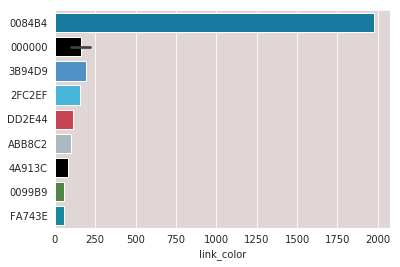

In [208]:
male_top_link_color = df[df['gender'] == 'male']['link_color'].value_counts().head(10)
male_top_link_color_idx = male_top_link_color.index
male_top_color = male_top_link_color_idx.values

male_top_color[1] = '000000'
male_top_color[6] = '000000'
print (male_top_color)
l = lambda x: '#'+x

sns.set_style("darkgrid", {"axes.facecolor": "#E0D6D6"})
sns.barplot (x = male_top_link_color, y = male_top_color , palette=list(map(l, male_top_color)))

['0084B4' '9266CC' 'F5ABB5' 'DD2E44' 'FF0000' '3B94D9' 'ABB8C2' '000000'
 '000000' 'B40B43']


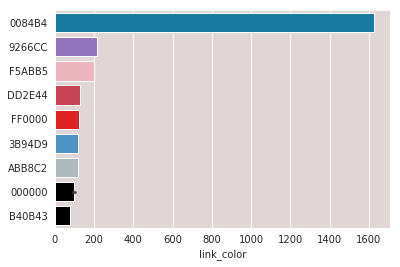

In [210]:
female_top_link_color = df[df['gender'] == 'female']['link_color'].value_counts().head(10)
female_top_link_color_idx = female_top_link_color.index
female_top_color = female_top_link_color_idx.values

female_top_color[7] = '000000'
female_top_color[8] = '000000'
print (female_top_color)
l = lambda x: '#'+x

sns.set_style("darkgrid", {"axes.facecolor": "#E0D6D6"})
sns.barplot (x = female_top_link_color, y = female_top_color , palette=list(map(l, female_top_color)))

['C0DEED' 'FFFFFF' '000000' 'EEEEEE' '181A1E' 'A8C7F7' '5ED4DC' 'BDDCAD'
 '65B0DA' '86A4A6']


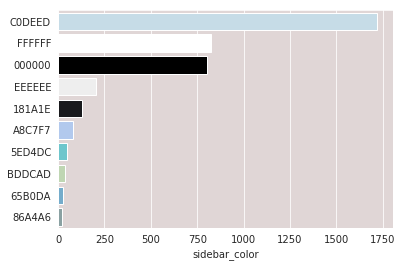

In [203]:
male_top_sidebar_color = df[df['gender'] == 'male']['sidebar_color'].value_counts().head(10)
male_top_sidebar_color_idx = male_top_sidebar_color.index
male_top_color = male_top_sidebar_color_idx.values

male_top_color[2] = '000000'
print (male_top_color)
l = lambda x: '#'+x

sns.set_style("darkgrid", {"axes.facecolor": "#E0D6D6"})
sns.barplot (x = male_top_sidebar_color, y = male_top_color , palette=list(map(l, male_top_color)))

['C0DEED' 'FFFFFF' '000000' 'EEEEEE' '65B0DA' '5ED4DC' '181A1E' 'CC3366'
 '829D5E' 'DBE9ED']


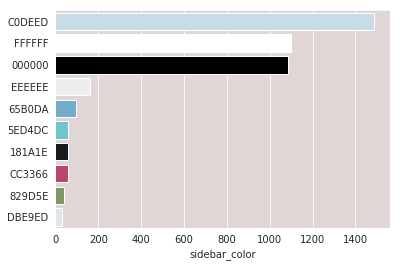

In [204]:
female_top_sidebar_color = df[df['gender'] == 'female']['sidebar_color'].value_counts().head(10)
female_top_sidebar_color_idx = female_top_sidebar_color.index
female_top_color = female_top_sidebar_color_idx.values

female_top_color[2] = '000000'
print (female_top_color)
l = lambda x: '#'+x

sns.set_style("darkgrid", {"axes.facecolor": "#E0D6D6"})
plot4 =sns.barplot (x = female_top_sidebar_color, y = female_top_color, palette=list(map(l, female_top_color)))
sns.set_style("darkgrid", {"axes.facecolor": "#FFFFFF"})

## Retweet_count, Fav_number i Tweet_count w zależności od płci

In [50]:
gfn_mean = (df.loc[:, ['gender', 'fav_number']]
            .groupby('gender')
            .mean()
            .sort_values(by='fav_number'))
gfn_mean

,fav_number
gender,
brand,2009.19
male,4800.67
female,6369.06


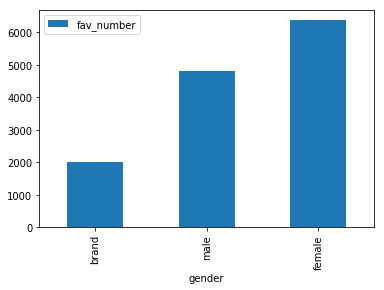

In [51]:
gfn_mean.plot.bar()

In [52]:
gtc_mean = (df.loc[:, ['gender', 'tweet_count']]
            .groupby('gender')
            .mean()
            .sort_values(by='tweet_count'))
gtc_mean

,tweet_count
gender,
female,26065.72
male,31260.50
brand,70313.51


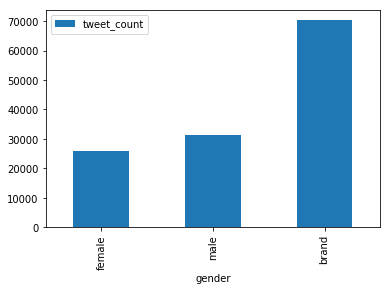

In [53]:
gtc_mean.plot.bar()

In [54]:
grc_mean = (df.loc[:, ['gender', 'retweet_count']]
            .groupby('gender')
            .mean()
            .sort_values(by='retweet_count'))
grc_mean

,retweet_count
gender,
female,0.03
brand,0.09
male,0.12


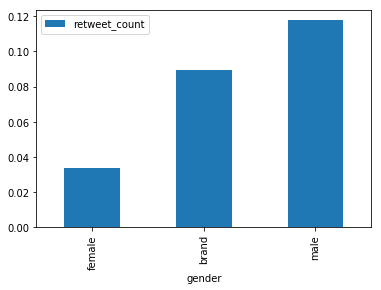

In [55]:
grc_mean.plot.bar()

In [56]:
(df.loc[:, 'link_color']
         .value_counts()
         #.groupby('link_color')
         #   
         #.sort_values(by='gender', ascending=False)
         .head(10)
        )


0084B4    4948
9999       428
3B94D9     412
DD2E44     308
9266CC     299
4A913C     264
ABB8C2     263
2FC2EF     251
0          248
F5ABB5     225
Name: link_color, dtype: int64